Dans ce notebook, vous apprendrez à classer des images de chats et de chiens en utilisant un transfert learning à partir d'un réseau pré-entraîné sur le jeu de données [ImageNet](https://www.image-net.org/update-mar-11-2021.php).

# Importation des données

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import urllib.request
import zipfile

import torch
from torchvision import datasets, transforms, models
from torchsummary import summary

# Chargement des données

Téléchargement des données

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
urllib.request.urlretrieve(_URL, "cats_and_dogs.zip")

('cats_and_dogs.zip', <http.client.HTTPMessage at 0x7e34b4782d70>)

Unzip du fichier.

In [3]:
with zipfile.ZipFile("cats_and_dogs.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
PATH = "cats_and_dogs_filtered"

Sauvegarde des PATH

In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Fixer les hyperparamètres

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

# Initialiser les générateurs

Pour le jeu d'entraînement.

Utilisez la fonction `Compose` de `transforms` avec en paramètre `Resize` et `ToTensor`.

In [7]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
  ])

Utilisez `ImageFolder` de `datasets` avec comme paramètre le path du dossier `train_dir` et `transform` initialisé précédemment.

In [8]:
dataset_train = datasets.ImageFolder(train_dir, transform)

Utilisez `DataLoader` pour initialiser le générateur de données avec `shuffle` à True et une taille de batch à 32.

In [9]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

Visualisez ce que ça donne.

torch.Size([64, 3, 128, 128])
torch.Size([64])


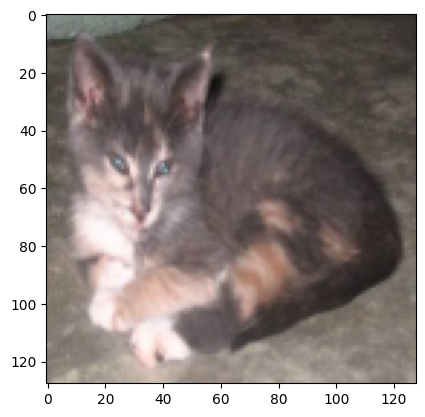

In [10]:
for x, y in dataloader_train:
    print(x.shape)
    print(y.shape)
    plt.imshow(np.transpose(x[0, :, :, :].squeeze(), (1, 2, 0)), cmap='gray')
    plt.show()
    break

Pour le jeu de validation.

Faire de même pour la validation.

In [11]:
dataset_test = datasets.ImageFolder(validation_dir, transform)

dataloader_test = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)

Visualisez le résultat.

torch.Size([64, 3, 128, 128])
torch.Size([64])


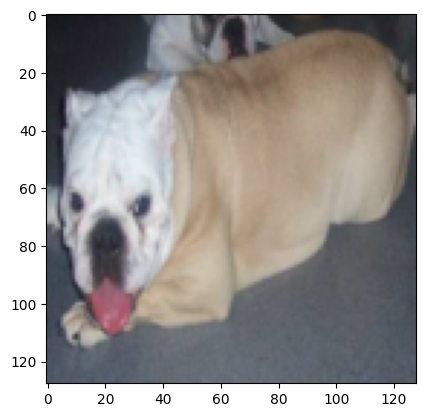

In [12]:
for x, y in dataloader_test:
    print(x.shape)
    print(y.shape)
    plt.imshow(np.transpose(x[0, :, :, :].squeeze(), (1, 2, 0)), cmap='gray')
    plt.show()
    break

#  Charger un modèle pré-entraîné

In [13]:
IMG_SHAPE = (3,) + IMG_SIZE

Vous allez utiliser un modèle pré-entrainé sur imagenet que vous allez finetuné pour différencier des photos de chats et de chiens.

Vous avez le choix entre plusieurs modèles.

Vous pouvez jeter un oeil [ici](https://pytorch.org/vision/stable/models.html#classification).

Dans ce notebook vous allez utilisé mobilenet_V2 car elle est assez léger ce qui réduira le temps de calcul.



Utilisez la fonction `hub.load` pour charger le modèle en question.

In [14]:
# Create the base model from the pre-trained model MobileNet V2
model = torch.hub.load("pytorch/vision", models.mobilenet_v2, weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 123MB/s]


Regardez l'architecture du modèle en utilisant `summary`.

Si votre notebook utilise le GPU vous aurez peut être besoin de lui spécifier `device='cpu'` en paramètre.

In [15]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

Appliquez le modèle sur `x`.

In [16]:
feature_batch = model.forward(x)

Regadrez la dimension de feature_batch.

In [17]:
feature_batch.shape

torch.Size([64, 1000])

On voit qu'il a 1000 sortie ce qui correspond au 1000 classes de ImageNet.

Pour notre application il nous faudra 2 classes, une pour les chiens, une pour les chats.

Le modèle est décomposé en une partie feature et une partie classifier.

In [18]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

La partie classifier est décomposé en une couche de drop out et une couche linéaire.

In [19]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

La couche reçoit en entrée 1280 variables.

In [20]:
model.classifier[1].in_features

1280

On le remplace par une couche qui reçoit la même chose mais qui n'aura qu'une neurone en sortie car nous allons faire la différence entre un chien et un chat.

Utilisez `Linear` avec 2 neurones pour remplacer le `Dropout`.

Utilisez `LogSoftmax` pour remplacer le `Linear` avec 1000 classes.

In [21]:
model.classifier[0] = torch.nn.Linear(1280, 2)
model.classifier[1] = torch.nn.LogSoftmax(dim=1)

La modification a bien été effectué.

In [22]:
model.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)

Visualisez le modèle maintenant en utilisant `summary`.

In [23]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

Fixer le modèle de base pour que les poids ne soient pas mis-à-jour.

Utiliser la méthode `requires_grad` de chacun des paramètres `param` pour changer la valeur de `True` à `False`.

In [25]:
for param in model.features.parameters():
    param.requires_grad = False

Vous pouvez maintenant regarder avec la fonction `summary` le nombre de parmètres entrainable qui ne correspond qu'à la dernière ligne.

In [26]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

# Les fonctions d'entraînement

In [27]:
def number_of_good_prediction(prediction:float, target:int):
  one_hot_prediction = np.argmax(prediction, axis=1)
  return np.sum(one_hot_prediction == target)

In [28]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [29]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor,
         metric_function)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  performance = metric_function(prediction.detach().numpy(), y_train.detach().numpy())

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss, performance

In [30]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader, metric_function):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []
    history_train_metrics = []
    history_test_metrics = []

    reference_performance = 0

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss, train_performance = step(model, optimizer, criterion, images, labels, metric_function)

        train_loss_batch += train_loss.detach().numpy()

        train_metric_batch += train_performance


      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_metric_batch += metric_function(prediction.detach().numpy(), labels.detach().numpy())

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      train_metric_batch /= len(trainloader.sampler)
      test_metric_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_metrics = np.append(history_train_metrics, train_metric_batch)
      history_test_metrics = np.append(history_test_metrics, test_metric_batch)

      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('train_metric : '+str(np.squeeze(train_metric_batch))+ ' test_metric : '+str(np.squeeze(test_metric_batch)))
      print('-------------------------------------------------------------------------------------------------')

      if test_metric_batch > reference_performance:
        reference_performance = test_metric_batch
        save_model(model, f'best_model_{test_metric_batch}.pth')

    return model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics


# Compiler le modèle

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [32]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

# Entraînement du modèle

Utilisez la fonction `fit` pour entraîner le modèle.

In [33]:
epoch = 5

model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics = fit(model, optimizer, criterion, epoch, dataloader_train, dataloader_test, number_of_good_prediction)

train_loss : 0.005832580342888832 test_loss : 0.0038300582133233545
train_metric : 0.8265 test_metric : 0.9
-------------------------------------------------------------------------------------------------
train_loss : 0.003784214973449707 test_loss : 0.0031866034865379333
train_metric : 0.9045 test_metric : 0.9235
-------------------------------------------------------------------------------------------------
train_loss : 0.0032336271554231646 test_loss : 0.0030211389660835266
train_metric : 0.9105 test_metric : 0.9235
-------------------------------------------------------------------------------------------------
train_loss : 0.0029629356041550635 test_loss : 0.002988262787461281
train_metric : 0.9205 test_metric : 0.923
-------------------------------------------------------------------------------------------------
train_loss : 0.0029998933784663676 test_loss : 0.0025719303451478483
train_metric : 0.928 test_metric : 0.9365
--------------------------------------------------------

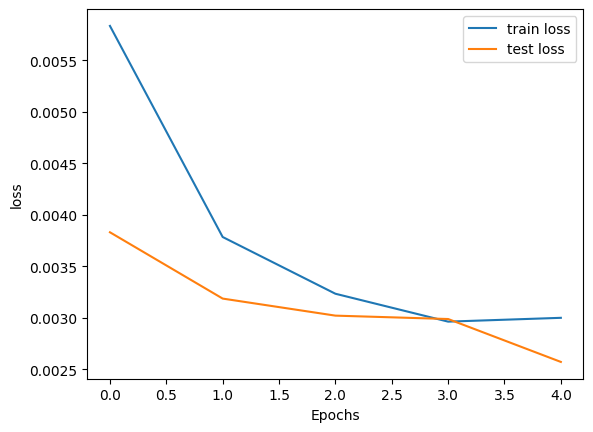

In [34]:
plt.plot(np.arange(epoch), history_train_loss, label='train loss')
plt.plot(np.arange(epoch), history_test_loss, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

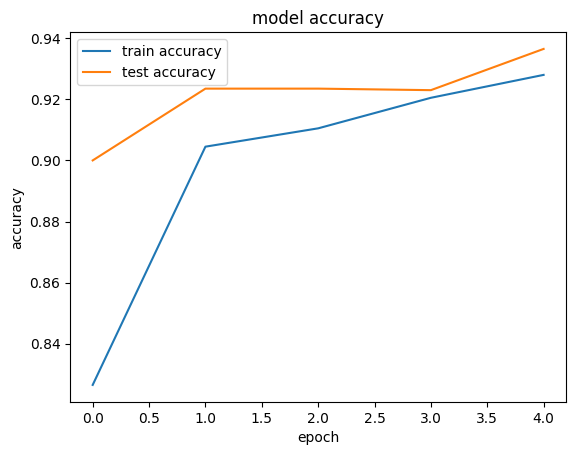

In [35]:
plt.plot(history_train_metrics, label='train accuracy')
plt.plot(history_test_metrics, label='test accuracy')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Fine tuning

Entraîner tous les paramètres du modèle.

Utiliser la méthode `requires_grad` de chacun des paramètres `param` pour changer la valeur de `False` à `True`.

In [36]:
for param in model.features.parameters():
    param.requires_grad = True

Utilisez `summary` pour visualiser le nombre de paramètre entraînable du modèle maintenant.

In [37]:
summary(model, (3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

Compiler le nouveau modèle

In [38]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

Continuer l'entraînement du modèle avec toutes les couches entrainables en utilisant la fonction `fit`.

In [ ]:
epoch = 5

model, history_train_loss_2, history_test_loss_2, history_train_metrics_2, history_test_metrics_2 = fit(model, optimizer, criterion, epoch, dataloader_train, dataloader_test, number_of_good_prediction)

train_loss : 0.005426307704299688 test_loss : 0.004376588143408298
train_metric : 0.8725 test_metric : 0.903
-------------------------------------------------------------------------------------------------
train_loss : 0.002179381923750043 test_loss : 0.0006313104219734669
train_metric : 0.938 test_metric : 0.9895
-------------------------------------------------------------------------------------------------
train_loss : 0.0011058451136341319 test_loss : 0.0004976530214771628
train_metric : 0.9715 test_metric : 0.9935
-------------------------------------------------------------------------------------------------


Concatenation des vecteurs de résultats.

In [ ]:
loss = np.concatenate([history_train_loss, history_train_loss_2])
val_loss = np.concatenate([history_test_loss, history_test_loss_2])

perf = np.concatenate([history_train_metrics, history_train_metrics_2])
val_perf = np.concatenate([history_test_metrics, history_test_metrics_2])

Visualiser les performances

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(perf, label='Training Accuracy')
plt.plot(val_perf, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([epoch-1,epoch-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([epoch-1,epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()